# Makes plots for the visual model network-network comparisons in Figure 9. 

The predictions of a given model for metamers generated from the other models are in the `network_network_evaluations` folder of each directory. This notebook pulls in the data from those network-network comparisons and plots them, and also compares the network responses to the human responses for each layer. 


In [1]:
import numpy as np
import pandas as pd
import os 
import glob
import math
import json
import scipy
import scipy.stats
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
import pickle as pckl
from PIL import Image
import seaborn as sns

import urllib.request, json
from scipy.io import loadmat

from model_analysis_folders import all_model_info

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams.update({'font.size': 6})



In [2]:
models_to_evaluate = [
                      'cornet_s', 'alexnet', 'vgg_19','resnet50','resnet101',
                      'resnet50_simclr', 'resnet50_moco_v2', 'resnet50_byol',
                      'resnet50_l2_3_robust', 'resnet50_linf_4_robust', 'resnet50_linf_8_robust',
                      "resnet50_random_l2_perturb", "resnet50_random_linf8_perturb",
                      'alexnet_l2_3_robust', 'alexnet_linf_8_robust',
                      "alexnet_random_l2_3_perturb", "alexnet_random_linf8_perturb",#  'legend_only'
                      'alexnet_early_checkpoint', 'alexnet_reduced_aliasing_early_checkpoint', 'vonealexnet_gaussian_noise_std4_fixed',
                     ]

plot_color_idx = [
                  5,0,7,3,4,
                  6,8,9,
                  10,11,12,
                  10,12,
                  1,2,
                  1,2,
                  0,13,14
                  ]

plot_style = ['-','-',
              '-','-','-',
              '-','-','-',
              '-','-','-',
              ':',':',
              '-','-',
              ':',':',
              '-.','-.','-.',
             ]

plot_num = [0,0,
            0,0,0, 
            1,1,1,
            2,2,2,
            2,2,
            3,3,
            3,3,
            4,4,4] 

network_network_folder = 'network_network_evaluations'

model_cmap = ["#000000","#004949","#009292","#ff6db6","#ffb6db",
 "#490092","#006ddb","#b66dff","#6db6ff","#b6dbff",
 "#920000","#924900","#db6d00","#24ff24","#ffff6d"]
assert (len(np.unique(plot_color_idx)) <= len(model_cmap)), 'Not enough colors to plot all of the networks!'

model_cmap_dict = {m:model_cmap[plot_color_idx[m_idx]] for m_idx, m in enumerate(models_to_evaluate)}
model_style_dict = {m:plot_style[m_idx] for m_idx, m in enumerate(models_to_evaluate)}

models_by_type = {'cornet_s':'standard',
              'alexnet':'standard',
              'vgg_19':'standard',
              'resnet50':'standard',
              'resnet101':'standard',
              'resnet50_simclr':'contrastive',
              'resnet50_moco_v2':'contrastive',
              'resnet50_byol':'contrastive',
              'resnet50_l2_3_robust':'adv_trained',
              'resnet50_linf_4_robust':'adv_trained',
              'resnet50_linf_8_robust':'adv_trained',
              "resnet50_random_l2_perturb":'rand_trained',
              "resnet50_random_linf8_perturb":'rand_trained',
              'alexnet_l2_3_robust':'adv_trained',
              'alexnet_linf_8_robust':'adv_trained',
              "alexnet_random_l2_3_perturb":'rand_trained',
              "alexnet_random_linf8_perturb":'rand_trained',
              "alexnet_early_checkpoint":'other',
              "alexnet_reduced_aliasing_early_checkpoint":'other',
              "vonealexnet_gaussian_noise_std4_fixed":'other',
             }

model_types = ['standard','contrastive','adv_trained','rand_trained', 'other']


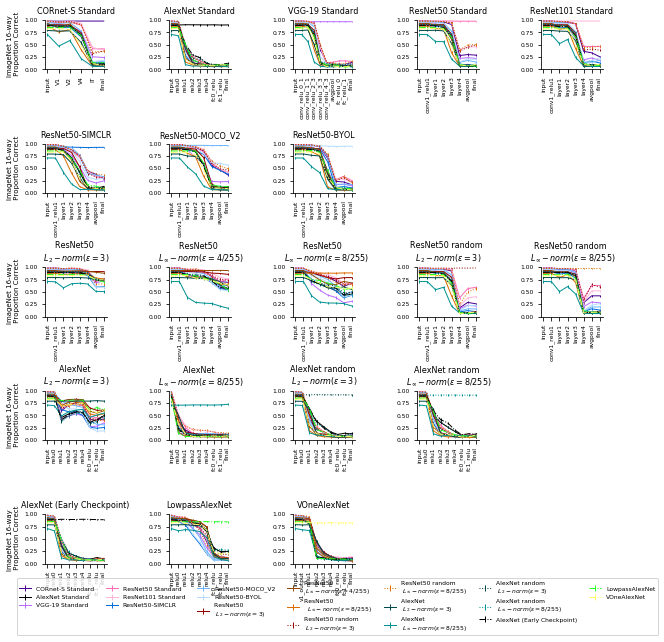

In [3]:
# Raw data -- all models. 16 way predictions because that is what the humans did (and this is how we validated the metamers)

current_row = 0
subplot_idx=0
num_rows = 5
num_columns = 5
fig, axs = plt.subplots(num_rows, num_columns, figsize=(2*num_columns,2*num_rows),
                        gridspec_kw={'hspace': 1.5, 'wspace': 1})

all_other_nets_evals = {}

# These will group together the MEASUREMENTS from a given model type. 
all_other_nets_evals_by_type = {}

for met_mod_idx, metamer_model in enumerate(models_to_evaluate): 
    all_other_nets_evals[metamer_model] = {}
    all_other_nets_evals_by_type[metamer_model] = {}
    metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[metamer_model]['layers']
    model_name = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[metamer_model]['paper_name']
    for layer in metamer_model_layers:
        all_other_nets_evals[metamer_model][layer] = []
        all_other_nets_evals_by_type[metamer_model][layer] = {m_type:[] for m_type in model_types}
    for measured_model in models_to_evaluate:
        measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[measured_model]
        pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
        try:
            eval_pckl = pckl.load(open(pckl_path, 'rb'))
        except FileNotFoundError:
            print('Missing %s'%pckl_path)
        # Store the data here. 
        for layer in metamer_model_layers:
            all_other_nets_evals[metamer_model][layer].append(eval_pckl['average_correct_16'][layer])
            all_other_nets_evals_by_type[metamer_model][layer][models_by_type[measured_model]].append(eval_pckl['average_correct_16'][layer])
        axs[current_row, subplot_idx].errorbar(range(len(metamer_model_layers)), 
                 [eval_pckl['average_correct_16'][layer] for layer in metamer_model_layers],
                     yerr=[eval_pckl['bootstrap_sem_16'][layer] for layer in metamer_model_layers],
                 color=model_cmap_dict[measured_model],
                 linewidth=1,
                 ls=model_style_dict[measured_model])
    axs[current_row, subplot_idx].set_title(model_name, fontsize=8)
    axs[current_row, subplot_idx].set_ylim([0,1])
    if subplot_idx==0:
        axs[current_row, subplot_idx].set_ylabel('ImageNet 16-way \n Proportion Correct', fontsize=7)
    if (current_row==(num_rows-1)) and subplot_idx==0:
        axs[current_row, subplot_idx].legend([all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[name]['paper_name'] for name in models_to_evaluate], loc='lower left', bbox_to_anchor=(-0.5, -1.5), fontsize=6, ncol=7)

    axs[current_row, subplot_idx].set_xticks(range(len(metamer_model_layers)))
    axs[current_row, subplot_idx].set_xticklabels(labels=[layer.split('_fake_relu')[0].split('_after_preproc')[0] for layer in metamer_model_layers], rotation=90, fontsize=6)
    # Hide the right and top spines
    axs[current_row, subplot_idx].spines['right'].set_visible(False)
    axs[current_row, subplot_idx].spines['top'].set_visible(False)

    try:
        if plot_num[met_mod_idx+1]!=current_row:
            for k in range(subplot_idx+1,num_columns):
                axs[current_row,k].set_axis_off()
            current_row+=1
            subplot_idx=0
        else:
            subplot_idx+=1
    except IndexError:
        for k in range(subplot_idx+1,num_columns):
            axs[current_row,k].set_axis_off()
        continue
        
plt.savefig('vision_model_model_comparisons.pdf')



In [4]:
# Load in the human performance. Make some helpers for this. 

In [6]:
def responses_network_by_layer_mat(all_subjects_answers, model_layers, conditions, experiment_params):
    network_response_dict = {}    
    condition_idx = list(conditions).index('Human  ')
    
    for l_idx, layer in enumerate(model_layers):
        network_response_dict[layer.strip()] = list(all_subjects_answers[:,l_idx,condition_idx])
        
    return network_response_dict

def combined_experiment_response_dictionaries(all_dicts):
    # all_dicts -- list of dictionaries output from respones_network_by_layer
    combined_experiment_dict = {}
    for experiment in all_dicts:
        for model in experiment.keys():
            if model not in list(combined_experiment_dict.keys()):
                combined_experiment_dict[model] = experiment[model]
            else:
                print('Duplicate model %s'%model)
                for layer in combined_experiment_dict[model].keys():
                    combined_experiment_dict[model][layer] = combined_experiment_dict[model][layer] + experiment[model][layer]
                    
    return combined_experiment_dict

def unpack_experiment_mat(mat_file_path):
    mat_contents = loadmat(mat_file_path)
    participant_data_matrix = mat_contents['participant_data_matrix']
    model_layers = mat_contents['model_layers']
    conditions = mat_contents['conditions']
    participants = mat_contents['participants'] # participant IDs were removed for public release
    return participant_data_matrix, model_layers, conditions, participants



In [7]:
experiment_list = [1,5,3,4,9] # do not compare HMAX experiment. 

all_experiment_dictionaries = []

for exp_num in experiment_list:
    experiment_name = all_model_info.TURK_IMAGE_EXPERIMENTS_GROUPINGS['experiment_%d'%exp_num]['paper_experiment_name']
    jsin_configs = all_model_info.TURK_IMAGE_EXPERIMENTS_GROUPINGS['experiment_%d'%exp_num]['experiment_params_web']

    with urllib.request.urlopen(jsin_configs) as url:
        experiment_params = json.loads(url.read().decode())

    plot_model_order = experiment_params['experiment_info']['networks']
    
    exp_response_dict = {}
    for n_idx, network in enumerate(experiment_params['experiment_info']['networks']):
        participant_data_matrix, model_layers, conditions, participants = unpack_experiment_mat(
            '../VisionBehavioralExperiments/EXP%d_ANALYSIS/VisionExperiment%d_network_vs_humans_datamatrix_%s_public.mat'%(exp_num, exp_num, network))
        
        exp_response_dict[network] = responses_network_by_layer_mat(participant_data_matrix, model_layers, conditions, experiment_params)

    all_experiment_dictionaries.append(exp_response_dict)

combined_experiment_dict = combined_experiment_response_dictionaries(all_experiment_dictionaries)


Duplicate model resnet50
Duplicate model resnet50
Duplicate model alexnet


3.0189924598256115e-63
3.2642752771528726e-61
1.6247809457749823e-41
0.7484944676522579


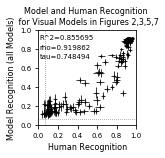

In [8]:
matplotlib.rcParams.update({'font.size': 7})

combined_human_means = []
combined_human_sem = []
combined_model_means = []
combined_model_sem = []

for model in combined_experiment_dict.keys():
    for layer in all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[model]['layers']:
        if ('input_after_preproc' not in layer):
            human_average = np.mean(combined_experiment_dict[model][layer])
            human_sem = np.std(combined_experiment_dict[model][layer])/np.sqrt(len(combined_experiment_dict[model][layer]))
            
            other_models_average = np.mean(all_other_nets_evals[model][layer])
            other_models_sem = np.std(all_other_nets_evals[model][layer])/np.sqrt(len(all_other_nets_evals[model][layer]))
            
            combined_human_means.append(human_average)
            combined_human_sem.append(human_sem)
            
            combined_model_means.append(other_models_average)
            combined_model_sem.append(other_models_sem)
    
plt.figure(figsize=(1.75,1.75))
plt.errorbar(combined_human_means, 
             combined_model_means,
             fmt='.',
             xerr=combined_human_sem,
             yerr=combined_model_sem,
             color='k',
             linewidth=0.75,
             markersize=2)
plt.plot([1/16,1/16],[0,1],':',color='grey', linewidth=0.75)
plt.plot([0,1],[1/16,1/16],':',color='grey', linewidth=0.75)

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('Human Recognition', fontsize=8)
plt.ylabel('Model Recognition (all Models)', fontsize=8)
plt.title('Model and Human Recognition \n for Visual Models in Figures 2,3,5,7', fontsize=8)

import scipy.stats
r_value, p_value = scipy.stats.pearsonr(combined_human_means, combined_model_means)
print(p_value)
plt.text(0.01,0.9,'R^2=%f'%r_value**2, fontsize=7)

r_value, p_value = scipy.stats.spearmanr(combined_human_means, combined_model_means)
print(p_value)
plt.text(0.01,0.8,'rho=%f'%r_value, fontsize=7)

r_value, p_value = scipy.stats.kendalltau(combined_human_means, combined_model_means)
print(p_value)
print(r_value)
plt.text(0.01,0.7,'tau=%f'%r_value, fontsize=7)

plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.savefig('ScatterModelHumanVisualModels_WITH_EXP9.pdf')

# Change back for the other plots in this notebook
matplotlib.rcParams.update({'font.size': 6})



# Average ResNet50 plots

In [14]:
model_groupings = {'Generated: Standard':['resnet50'],
                   'Generated: Constrastive':['resnet50_simclr', 'resnet50_moco_v2', 'resnet50_byol'],
                   'Generated: adversarially_trained':['resnet50_l2_3_robust', 'resnet50_linf_4_robust', 'resnet50_linf_8_robust'],
                   # 'Generated: random_perturbations':["resnet50_random_l2_perturb", "resnet50_random_linf8_perturb"]
                  }


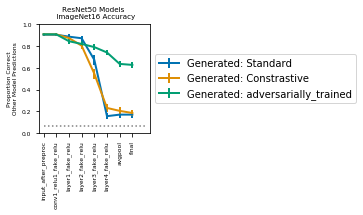

In [15]:
plt.figure(figsize=(2,2))
all_group_data = {}

import seaborn as sns

for group_idx, metamer_group in enumerate(model_groupings.keys()):
    all_group_data[metamer_group] = {}
    for met_mod_idx, metamer_model in enumerate(model_groupings[metamer_group]):
        all_group_data[metamer_group][metamer_model] = {}
        if (group_idx==0) and (met_mod_idx==0):
            metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[metamer_model]['layers']
        else:
            # For this type of plot, the layers need to be *exactly* the same between the models. 
            assert metamer_model_layers == all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[metamer_model]['layers']
        for measured_model in models_to_evaluate:
            if measured_model != metamer_model:
                measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[measured_model]
                pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
                eval_pckl = pckl.load(open(pckl_path, 'rb'))
                average_correct = [eval_pckl['average_correct_16'][layer] for layer in metamer_model_layers]
                # Save the average group data. We will do the plotting afterwards. 
                all_group_data[metamer_group][metamer_model][measured_model] = average_correct

    # First average across the metamer generation models
    average_data_from_group = {}
    for measured_model in models_to_evaluate:
        collapse_data = []
        for metamer_model in model_groupings[metamer_group]:
            if measured_model != metamer_model:
                collapse_data.append(all_group_data[metamer_group][metamer_model][measured_model])
        if len(model_groupings[metamer_group])>1:
            average_data_from_group[measured_model] = np.mean(np.array(collapse_data),0)
        else:
            if measured_model == model_groupings[metamer_group][0]:
                average_data_from_group[measured_model] = np.ones((len(metamer_model_layers)))*np.nan
            else:
                average_data_from_group[measured_model] = np.squeeze(np.array(collapse_data))
    
    average_over_all_measured_models = np.squeeze(np.nanmean(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0))
    sem_over_all_measured_models = np.squeeze(np.nanstd(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0)/np.sqrt(len(models_to_evaluate)-1)) # N-1 because we don't use the same model for predictions
    plt.errorbar(range(len(metamer_model_layers)),
                 average_over_all_measured_models, 
                 yerr=sem_over_all_measured_models,
                 linewidth=2,
                 label=metamer_group,
                 color = sns.color_palette("colorblind")[group_idx]
                 )
    
plt.plot([0,len(metamer_model_layers)],[1/16,1/16],':',color='grey')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.title('ResNet50 Models \n ImageNet16 Accuracy')
plt.ylim([0,1])
plt.ylabel('Proportion Correct\n Other Model Predictions')
plt.xticks(range(len(metamer_model_layers)), metamer_model_layers, rotation=90)
          

plt.savefig('ResNetGroupFourModelTypesModelModelComparisons.pdf')

# Experiment 9 (LowpassAlexNet and VOneAlexNet) Average Plots

In [16]:
model_groupings = {'Standard AlexNet\n(Figure 7 checkpoint)':['alexnet_early_checkpoint'],
                   'LowpassAlexNet':['alexnet_reduced_aliasing_early_checkpoint'],
                   'VOneAlexNet':['vonealexnet_gaussian_noise_std4_fixed'],
                   # 'Generated: random_perturbations':["resnet50_random_l2_perturb", "resnet50_random_linf8_perturb"]
                  }

group_colors = ['k', sns.color_palette("colorblind")[1], sns.color_palette("colorblind")[2]]


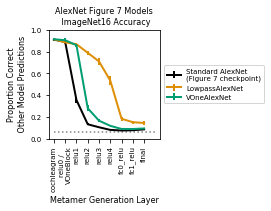

In [17]:
matplotlib.rcParams.update({'font.size': 7})

plt.figure(figsize=(2,2))
all_group_data = {}

import seaborn as sns


layer_names = ['cochleagram',
              'relu0 /\nVOneBlock',
              'relu1',
              'relu2',
              'relu3',
              'relu4',
              'fc0_relu',
              'fc1_relu',
              'final'
              ]

for group_idx, metamer_group in enumerate(model_groupings.keys()):
    all_group_data[metamer_group] = {}
    for met_mod_idx, metamer_model in enumerate(model_groupings[metamer_group]):
        all_group_data[metamer_group][metamer_model] = {}
        # if (group_idx==0) and (met_mod_idx==0):
        metamer_model_layers = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[metamer_model]['layers']
        for measured_model in models_to_evaluate:
            if measured_model != metamer_model:
                measured_model_info = all_model_info.ALL_NETWORKS_AND_LAYERS_IMAGES[measured_model]
                pckl_path = os.path.join(measured_model_info['location'], network_network_folder, 'accuracy_on_metamers_from_%s.pckl'%metamer_model)
                eval_pckl = pckl.load(open(pckl_path, 'rb'))
                average_correct = [eval_pckl['average_correct_16'][layer] for layer in metamer_model_layers]
                # Save the average group data. We will do the plotting afterwards. 
                all_group_data[metamer_group][metamer_model][measured_model] = average_correct

    # First average across the metamer generation models
    average_data_from_group = {}
    for measured_model in models_to_evaluate:
        collapse_data = []
        for metamer_model in model_groupings[metamer_group]:
            if measured_model != metamer_model:
                collapse_data.append(all_group_data[metamer_group][metamer_model][measured_model])
        if len(model_groupings[metamer_group])>1:
            average_data_from_group[measured_model] = np.mean(np.array(collapse_data),0)
        else:
            if measured_model == model_groupings[metamer_group][0]:
                average_data_from_group[measured_model] = np.ones((len(metamer_model_layers)))*np.nan
            else:
                average_data_from_group[measured_model] = np.squeeze(np.array(collapse_data))
    
    average_over_all_measured_models = np.squeeze(np.nanmean(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0))
    sem_over_all_measured_models = np.squeeze(np.nanstd(np.array([average_data_from_group[measured_model] for measured_model in average_data_from_group.keys()]),0)/np.sqrt(len(models_to_evaluate)-1)) # N-1 because we don't use the same model for predictions
    plt.errorbar(range(len(metamer_model_layers)),
                 average_over_all_measured_models, 
                 yerr=sem_over_all_measured_models,
                 linewidth=2,
                 label=metamer_group,
                 color = group_colors[group_idx]
                 )

plt.plot([0,len(metamer_model_layers)],[1/16,1/16],':',color='grey')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
plt.title('AlexNet Figure 7 Models \n ImageNet16 Accuracy', fontsize=8)
plt.ylim([0,1])
plt.ylabel('Proportion Correct\n Other Model Predictions', fontsize=8)
plt.xticks(range(len(metamer_model_layers)), layer_names, rotation=90)
plt.xlabel('Metamer Generation Layer', fontsize=8)    

plt.savefig('Exp9LowpassAndVoneNetModelModelComparisons.pdf')

matplotlib.rcParams.update({'font.size': 6})
